In [1]:
import findspark

In [2]:
findspark.init('/home/dbmello/spark-3.5.3-bin-hadoop3')

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName('airports').getOrCreate()

24/10/18 10:54:10 WARN Utils: Your hostname, dbmello-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.0.230 instead (on interface enp0s3)
24/10/18 10:54:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/18 10:54:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 1. <span style="color: darkblue;">Extract, Treat and Load</span>

## 1.1 Extract

In [72]:
df_airports_db = spark.read.csv('./data/airports-database.csv', inferSchema=True, header=True)

In [73]:
df_airports_db.printSchema()

root
 |-- id: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dep_time: double (nullable = true)
 |-- sched_dep_time: integer (nullable = true)
 |-- dep_delay: double (nullable = true)
 |-- arr_time: double (nullable = true)
 |-- sched_arr_time: integer (nullable = true)
 |-- arr_delay: double (nullable = true)
 |-- carrier: string (nullable = true)
 |-- flight: integer (nullable = true)
 |-- tailnum: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- air_time: double (nullable = true)
 |-- distance: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- time_hour: timestamp (nullable = true)
 |-- name: string (nullable = true)



In [74]:
df_airports_db.head(1)

[Row(id=0, year=2013, month=1, day=1, dep_time=517.0, sched_dep_time=515, dep_delay=2.0, arr_time=830.0, sched_arr_time=819, arr_delay=11.0, carrier='UA', flight=1545, tailnum='N14228', origin='EWR', dest='IAH', air_time=227.0, distance=1400, hour=5, minute=15, time_hour=datetime.datetime(2013, 1, 1, 5, 0), name='United Air Lines Inc.')]

In [75]:
df_airports_db.count()

336776

In [76]:
from pyspark.sql.functions import format_number

describe_df = df_airports_db.describe()

# Formata variáveis numéricas para exibir somente 2 casas decimais
formatted_df = describe_df.select(
    describe_df["summary"],
    format_number(describe_df['year'].cast("float"), 2).alias("year"),
    format_number(describe_df['month'].cast("float"), 2).alias("month"),
    format_number(describe_df['day'].cast("float"), 2).alias("day"),
    format_number(describe_df['dep_time'].cast("float"), 2).alias("dep_time"),
    format_number(describe_df['dep_delay'].cast("float"), 2).alias("dep_delay"),
    format_number(describe_df['arr_time'].cast("float"), 2).alias("arr_time"),
    format_number(describe_df['arr_delay'].cast("float"), 2).alias("arr_delay"),
    format_number(describe_df['air_time'].cast("float"), 2).alias("air_time"),
    format_number(describe_df['distance'].cast("float"), 2).alias("distance")
)

formatted_df.show()

+-------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|summary|      year|     month|       day|  dep_time| dep_delay|  arr_time| arr_delay|  air_time|  distance|
+-------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|  count|336,776.00|336,776.00|336,776.00|328,521.00|328,521.00|328,063.00|327,346.00|327,346.00|336,776.00|
|   mean|  2,013.00|      6.55|     15.71|  1,349.11|     12.64|  1,502.06|      6.90|    150.69|  1,039.91|
| stddev|      0.00|      3.41|      8.77|    488.28|     40.21|    533.26|     44.63|     93.69|    733.23|
|    min|  2,013.00|      1.00|      1.00|      1.00|    -43.00|      1.00|    -86.00|     20.00|     17.00|
|    max|  2,013.00|     12.00|     31.00|  2,400.00|  1,301.00|  2,400.00|  1,272.00|    695.00|  4,983.00|
+-------+----------+----------+----------+----------+----------+----------+----------+----------+----------+



### 1.1.1 Dados Duplicados

In [77]:
df_airports_db.count() == df_airports_db.dropDuplicates().count()

True

**Não há dados duplicados.**

### 1.1.2 Missing Data

#### Missing Data Helper Function print_missing_data()

In [78]:
# from pyspark.sql.functions import col, sum
from pyspark.sql import functions as F

def print_missing_data(df):
    null_counts = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
    filtered_null_counts = null_counts.select([F.col(c) for c in null_counts.columns if null_counts.select(F.col(c)).first()[0] > 0])
    filtered_null_counts.show()

In [79]:
print_missing_data(df_airports_db)

+--------+---------+--------+---------+-------+--------+
|dep_time|dep_delay|arr_time|arr_delay|tailnum|air_time|
+--------+---------+--------+---------+-------+--------+
|    8255|     8255|    8713|     9430|   2512|    9430|
+--------+---------+--------+---------+-------+--------+



#### Voos cancelados

In [80]:
df_cancel = df_airports_db.filter((df_airports_db.dep_time.isNull()) & (df_airports_db.arr_time.isNull()))

In [81]:
df_cancel.count()

8255

#### Voos Realizados

In [82]:
df_real = df_airports_db.filter((df_airports_db.dep_time.isNotNull()) | (df_airports_db.arr_time.isNotNull()))

In [83]:
df_real.count()

328521

In [84]:
print_missing_data(df_real)

24/10/17 10:44:22 WARN Executor: Issue communicating with driver in heartbeater]
org.apache.spark.rpc.RpcTimeoutException: Cannot receive any reply from 10.0.0.230:46357 in 10000 milliseconds. This timeout is controlled by spark.executor.heartbeatInterval
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at scala.util.Failure.recover(Try.scala:234)
	at scala.concurrent.Future.$anonfun$recover$1(Future.scala:395)
	at scala.concurrent.impl.Promise.liftedTree1$1(Promise.scala:33)
	at scala.concurrent.impl.Promise.$anonfun$transform$1(Promise.scala:33)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at org.apache.spark.util.Threa

+--------+---------+--------+
|arr_time|arr_delay|air_time|
+--------+---------+--------+
|     458|     1175|    1175|
+--------+---------+--------+



In [85]:
df = df_real.na.drop(how='any')

In [86]:
df.count()

327346

## 1.2 Treat

### 1.2.1 Datetime formats

In [87]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dep_time: double (nullable = true)
 |-- sched_dep_time: integer (nullable = true)
 |-- dep_delay: double (nullable = true)
 |-- arr_time: double (nullable = true)
 |-- sched_arr_time: integer (nullable = true)
 |-- arr_delay: double (nullable = true)
 |-- carrier: string (nullable = true)
 |-- flight: integer (nullable = true)
 |-- tailnum: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- air_time: double (nullable = true)
 |-- distance: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- time_hour: timestamp (nullable = true)
 |-- name: string (nullable = true)



In [88]:
from pyspark.sql import functions as F
from pyspark.sql.functions import concat_ws, col, lpad, to_date, concat, lit, to_timestamp, expr

# ORIGEM ******************************************************************************************

# Data Programada Voo Origem
df = df.withColumn('sched_dep_date', 
                   to_date(concat_ws('-', F.col('year'), 
                                    lpad(F.col('month'), 2, '0'), 
                                    lpad(F.col('day'), 2, '0')), 'yyyy-MM-dd'))

# Hora Programada Voo Origem
df = df.withColumn('sched_dep_hour', F.floor(df.sched_dep_time / 100)) \
        .withColumn('sched_dep_minute', df.sched_dep_time % 100) \
        .withColumn('sched_dep_time_frmt', 
                   F.concat(F.lpad(F.col('sched_dep_hour'), 2, '0'), 
                            F.lit(':'), 
                            F.lpad(F.col('sched_dep_minute'), 2, '0')))

# Datetime Programado Voo Origem
df = df.withColumn('sched_dep_timestamp', 
               concat(df.sched_dep_date, lit(' '), df.sched_dep_time_frmt)) \
        .withColumn('sched_dep_timestamp', 
               to_timestamp(F.col('sched_dep_timestamp'), 'yyyy-MM-dd HH:mm'))

# Data Realizada Voo Origem
df = df.withColumn('dep_timestamp', expr("sched_dep_timestamp + dep_delay * interval 1 minute"))
df = df.withColumn('dep_timestamp', 
               to_timestamp(df.dep_timestamp, 'yyyy-MM-dd HH:mm')) \
        .withColumn('dep_date', to_date(F.col('dep_timestamp'), 'yyyy-MM-dd'))


# DESTINO ******************************************************************************************

# Data Realizada Voo Destino
df = df.withColumn('arr_date_timestamp', expr("dep_timestamp + air_time * interval 1 minute"))
df = df.withColumn('arr_date', to_date('arr_date_timestamp', 'yyyy-MM-dd'))

# Hora Realizada Voo Destino
df = df.withColumn('arr_hour', F.floor(df.arr_time / 100)) \
        .withColumn('arr_minute', df.arr_time % 100) \
        .withColumn('arr_time_frmt', 
                   F.concat(F.lpad(F.col('arr_hour'), 2, '0'), 
                            F.lit(':'), 
                            F.lpad(F.col('arr_minute'), 2, '0')))

# Step 3: Combine flight_date and sched_dep_time to create a full timestamp
df = df.withColumn('arr_timestamp', 
               concat(df.arr_date, lit(' '), df.arr_time_frmt)) \
        .withColumn('arr_timestamp', 
               to_timestamp(F.col('arr_timestamp'), 'yyyy-MM-dd HH:mm'))

In [89]:
df = df.select('id',
            'dep_date',
            'dep_timestamp',
            'dep_delay',
            'arr_date',
            'arr_timestamp',
            'arr_delay',
            'origin',
            'dest',
            'carrier',
            'name',
            'tailnum',
            'flight',
            'air_time',
            'distance')

In [90]:
df.dtypes

[('id', 'int'),
 ('dep_date', 'date'),
 ('dep_timestamp', 'timestamp'),
 ('dep_delay', 'double'),
 ('arr_date', 'date'),
 ('arr_timestamp', 'timestamp'),
 ('arr_delay', 'double'),
 ('origin', 'string'),
 ('dest', 'string'),
 ('carrier', 'string'),
 ('name', 'string'),
 ('tailnum', 'string'),
 ('flight', 'int'),
 ('air_time', 'double'),
 ('distance', 'int')]

#### Saving airports-database-clean.csv

In [99]:
# spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
# df.write.mode("overwrite").csv('airports-database-clean.csv', header=True)

## 1.3 API's

### 1.3.1 AirportDB API

In [31]:
import os

In [32]:
os.environ['AIRPORTDB_API_KEY'] = '61b44c03cacbb4d0868bf8bfd16446bebf5250b983cf39256dd7891484a50ebf23b25b44379233c4bf6e7000155491dc'

In [ ]:
import requests
import os
from pyspark.sql import Row

# Function to get airport coordinates from AirportDB API
def get_airport_coordinates(airport_code):
    airportdb_key = os.getenv('AIRPORTDB_API_KEY')
    
    url = f"https://airportdb.io/api/v1/airport/K{airport_code}?apiToken={airportdb_key}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        airport_name = data.get('name')
        latitude = data.get('latitude_deg')
        longitude = data.get('longitude_deg')
        return airport_name, latitude, longitude
    else:
        return None, None, None

# Extract distinct airports (both origin and destination)
distinct_airports = df.select('origin').distinct().union(df.select('dest').distinct()).rdd.map(lambda row: row[0]).collect()

# Get coordinates for each airport
airport_data = []
for airport in distinct_airports:
    airport_name, latitude, longitude = get_airport_coordinates(airport)
    print(airport_name)
    if airport_name:  # Only include valid results
        airport_data.append(Row(airport_code=airport, airport_name=airport_name, latitude=latitude, longitude=longitude))

# Convert to a Spark DataFrame
airport_df = spark.createDataFrame(airport_data)

In [64]:
airport_df.show()

+------------+--------------------+------------------+------------------+
|airport_code|        airport_name|          latitude|         longitude|
+------------+--------------------+------------------+------------------+
|         LGA|  La Guardia Airport|         40.777199|        -73.872597|
|         EWR|Newark Liberty In...|         40.692501|        -74.168701|
|         JFK|John F Kennedy In...|         40.639801|          -73.7789|
|         MSY|Louis Armstrong N...| 29.99340057373047|-90.25800323486328|
|         SNA|John Wayne Airpor...|         33.675701|       -117.867996|
|         BUR|    Bob Hope Airport|         34.197703|       -118.356378|
|         GRR|Gerald R. Ford In...|       42.88079834|      -85.52279663|
|         MYR|Myrtle Beach Inte...|     33.6796989441|    -78.9282989502|
|         GSO|Piedmont Triad In...|36.097801208496094|-79.93730163574219|
|         PVD|Theodore Francis ...|         41.732601|        -71.420403|
|         OAK|Metropolitan Oakl...|   

In [63]:
airport_df.count()

101

#### Saving airport_coordinates.csv file

In [33]:
#airport_df.write.mode("overwrite").csv('airport_coordinates.csv', header=True)

#### Importing airport_coordinates.csv file

In [35]:
airport_df = spark.read.csv('./data/airport_coordinates.csv', inferSchema=True, header=True)

In [36]:
airport_df.count()

101

In [37]:
airport_df.columns

['airport_code', 'airport_name', 'latitude', 'longitude']

In [38]:
df.columns

['id',
 'dep_date',
 'dep_timestamp',
 'dep_delay',
 'arr_date',
 'arr_timestamp',
 'arr_delay',
 'origin',
 'dest',
 'carrier',
 'name',
 'tailnum',
 'flight',
 'air_time',
 'distance']

In [39]:
# Join with origin coordinates
df_with_origin_coords = df.join(airport_df, df.origin == airport_df.airport_code, 'left') \
    .select('dep_date', 'origin', 'airport_name', 'latitude', 'longitude') \
    .withColumnRenamed('dep_date', 'date') \
    .withColumnRenamed('origin', 'airport_code')

# Join with destination coordinates
df_with_dest_coords = df.join(airport_df, df.dest == airport_df.airport_code, 'left') \
    .select('arr_date', 'dest', 'airport_name', 'latitude', 'longitude') \
    .withColumnRenamed('arr_date', 'date') \
    .withColumnRenamed('dest', 'airport_code')

# Union the two DataFrames (origin and destination)
df_combined = df_with_origin_coords.union(df_with_dest_coords)

# Select distinct values
df_key = df_combined.distinct()

In [42]:
df_key.show()

+----------+------------+--------------------+---------+----------+
|      date|airport_code|        airport_name| latitude| longitude|
+----------+------------+--------------------+---------+----------+
|2013-10-19|         JFK|John F Kennedy In...|40.639801|  -73.7789|
|2013-11-13|         LGA|  La Guardia Airport|40.777199|-73.872597|
|2013-11-28|         JFK|John F Kennedy In...|40.639801|  -73.7789|
|2013-03-01|         EWR|Newark Liberty In...|40.692501|-74.168701|
|2013-04-05|         LGA|  La Guardia Airport|40.777199|-73.872597|
|2013-04-17|         JFK|John F Kennedy In...|40.639801|  -73.7789|
|2013-01-06|         LGA|  La Guardia Airport|40.777199|-73.872597|
|2013-12-23|         EWR|Newark Liberty In...|40.692501|-74.168701|
|2013-12-29|         JFK|John F Kennedy In...|40.639801|  -73.7789|
|2013-11-16|         LGA|  La Guardia Airport|40.777199|-73.872597|
|2013-12-31|         LGA|  La Guardia Airport|40.777199|-73.872597|
|2013-03-04|         LGA|  La Guardia Airport|40

In [41]:
df_key.count()

31864

### 1.3.2 Weatherbit API

In [31]:
import os

In [60]:
os.environ['WEATHERBIT_API_KEY'] = 'e0c14a97b2f24554b5352d134aa059a5'

#### Import wind_speed.csv and continuing

In [44]:
wind_speed_df = spark.read.csv('./data/wind_speed.csv', inferSchema=True, header=True)

In [45]:
wind_speed_df.count()

3525

In [46]:
wind_speed_df.printSchema()

root
 |-- date: date (nullable = true)
 |-- airport_code: string (nullable = true)
 |-- airport_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- wind_speed: double (nullable = true)



In [47]:
from pyspark.sql.functions import monotonically_increasing_id, col
from pyspark.sql.types import IntegerType

# Add a row number column using monotonically_increasing_id and cast it to IntegerType
df_with_row_numbers = df_key.withColumn("row_num", monotonically_increasing_id().cast(IntegerType()))

# Get the total count of the DataFrame
row_count = wind_speed_df.count()

# Select rows starting from index 1493
df_key_filtered = df_with_row_numbers.filter(col('row_num') >= wind_speed_df.count()).drop('row_num')

In [48]:
df_key_filtered.show()

+----------+------------+--------------------+------------------+-------------------+
|      date|airport_code|        airport_name|          latitude|          longitude|
+----------+------------+--------------------+------------------+-------------------+
|2013-01-17|         BDL|Bradley Internati...|     41.9388999939| -72.68319702149999|
|2013-01-18|         SAN|San Diego Interna...|     32.7336006165|     -117.190002441|
|2013-01-22|         MKE|General Mitchell ...|42.947200775146484| -87.89659881591797|
|2013-01-23|         CRW|      Yeager Airport| 38.37310028076172| -81.59320068359375|
|2013-01-25|         HOU|William P Hobby A...|       29.64539909|       -95.27890015|
|2013-01-26|         JAX|Jacksonville Inte...| 30.49410057067871| -81.68789672851562|
|2013-01-27|         MIA|Miami Internation...| 25.79319953918457| -80.29060363769531|
|2013-01-27|         BOS|Logan Internation...|           42.3643|         -71.005203|
|2013-01-28|         PBI|Palm Beach Intern...| 26.6832

In [53]:
df_key_filtered.count()

28339

In [118]:
import pandas as pd

cols = ['date','airport_code','airport_name','latitude','longitude','wind_speed']
df_pandas = pd.DataFrame(wind_speed_data,columns=cols)

In [120]:
df_pandas.to_csv('wind_speed_pandas.csv')

In [ ]:
spark.stop()

In [ ]:
import requests
import os
from datetime import datetime, timedelta
from time import sleep
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, DateType

# Function to get wind speed for a specific date and location
def get_wind_speed(latitude, longitude, flight_date, max_retries=3, backoff_time=5):
    weatherbit_key = os.getenv('WEATHERBIT_API_KEY')
    
    # Convert flight_date to datetime and get the next day for end_date
    start_date = date
    end_date = start_date + timedelta(days=1)
    
    url = 'https://api.weatherbit.io/v2.0/history/daily'
    params = {
        'lat': latitude,
        'lon': longitude,
        'start_date': start_date,
        'end_date': end_date,
        'key': weatherbit_key
    }
    headers = {'Accept': 'application/json'}

    for attempt in range(max_retries):
        try:
            response = requests.get(url, params=params, headers=headers, timeout=10)  # Set a 10-second timeout
            response.raise_for_status()  # Raise an error if the request failed
            data = response.json()
            
            if 'data' in data and len(data['data']) > 0:
                wind_speed = data['data'][0]['wind_spd']
                return wind_speed
            else:
                return None  # Handle cases where no data is returned
            
        except requests.exceptions.Timeout:
            print(f"Timeout occurred. Retrying... ({attempt + 1}/{max_retries})")
            sleep(backoff_time)  # Wait for a few seconds before retrying
        
        except requests.exceptions.RequestException as e:
            print(f"An error occurred: {e}")
            if response.status_code == 429:
                print(f"Rate limit exceeded. Sleeping for {backoff_time} seconds.")
                sleep(backoff_time)
                break
    
    print(f"Failed to retrieve wind speed after {max_retries} attempts.")
    return None

# Collect distinct values from df_final
distinct_airport_data = df_key_filtered.collect()

# Query Weatherbit API for each distinct airport and flight date
count = 0
wind_speed_data = []

for row in distinct_airport_data:
    
    date = row['date']
    airport_code = row['airport_code']
    airport_name = row['airport_name']
    latitude = row['latitude']
    longitude = row['longitude']
    
    wind_speed = get_wind_speed(latitude, longitude, date)
    
    # Append the result only if valid wind speed is obtained
    if wind_speed is not None:
        wind_speed_data.append(Row(date=date, airport_code=airport_code, airport_name=airport_name, latitude=latitude, longitude=longitude, wind_speed=float(wind_speed)))


# Define a schema with consistent types
schema = StructType([
    StructField("date", DateType(), True),
    StructField("airport_code", StringType(), True),
    StructField("airport_name", StringType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("longitude", DoubleType(), True),
    StructField("wind_speed", DoubleType(), True)
])

# Ensure no empty values are passed to Spark
if wind_speed_data:
    # Convert to a Spark DataFrame
    wind_speed_df_tmp = spark.createDataFrame(wind_speed_data, schema=schema)
    # Append on existing DataFrame and create a new one (avoid overwriting)
    wind_speed_df_new = wind_speed_df.union(wind_speed_df_tmp)
else:
    print("No valid wind speed data was retrieved.")

In [128]:
wind_speed_df_new.dropDuplicates().count()

4499

In [129]:
wind_speed_df = wind_speed_df_new.dropDuplicates()

#### Saving wind_speed.csv

In [130]:
# spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
# wind_speed_df.write.mode("overwrite").csv('./data/wind_speed.csv', header=True)

## 1.4 Joining Data

In [5]:
wind_speed_df = spark.read.csv('./data/wind_speed.csv', inferSchema=True, header=True)

24/10/18 10:54:34 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [6]:
wind_speed_df.printSchema()

root
 |-- date: date (nullable = true)
 |-- airport_code: string (nullable = true)
 |-- airport_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- wind_speed: double (nullable = true)



In [7]:
wind_speed_df.count()

4499

In [8]:
df = spark.read.csv('./data/airports-database-clean.csv', inferSchema=True, header=True)

In [9]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- dep_date: date (nullable = true)
 |-- dep_timestamp: timestamp (nullable = true)
 |-- dep_delay: double (nullable = true)
 |-- arr_date: date (nullable = true)
 |-- arr_timestamp: timestamp (nullable = true)
 |-- arr_delay: double (nullable = true)
 |-- origin: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- carrier: string (nullable = true)
 |-- name: string (nullable = true)
 |-- tailnum: string (nullable = true)
 |-- flight: integer (nullable = true)
 |-- air_time: double (nullable = true)
 |-- distance: integer (nullable = true)



In [10]:
df.count()

327346

In [11]:
# Alias the wind_speed_df for the origin and destination joins
wind_speed_origin = wind_speed_df.alias("wind_origin")
wind_speed_dest = wind_speed_df.alias("wind_dest")

# Join on 'origin' airport and get wind speed for the departure airport
df_with_origin_wind = df.join(wind_speed_origin, 
                              (df["dep_date"] == wind_speed_origin["date"]) & 
                              (df["origin"] == wind_speed_origin["airport_code"]),
                              how="left") \
                        .withColumnRenamed("wind_speed", "origin_wind_speed") \
                        .withColumnRenamed("airport_name", "origin_airport_name")

# Join on 'dest' airport and get wind speed for the arrival airport
df_with_wind_speed = df_with_origin_wind.join(wind_speed_dest, 
                                              (df_with_origin_wind["arr_date"] == wind_speed_dest["date"]) & 
                                              (df_with_origin_wind["dest"] == wind_speed_dest["airport_code"]),
                                              how="left") \
                                        .withColumnRenamed("wind_speed", "dest_wind_speed") \
                                        .withColumnRenamed("airport_name", "dest_airport_name")

In [12]:
df_with_wind_speed.columns

['id',
 'dep_date',
 'dep_timestamp',
 'dep_delay',
 'arr_date',
 'arr_timestamp',
 'arr_delay',
 'origin',
 'dest',
 'carrier',
 'name',
 'tailnum',
 'flight',
 'air_time',
 'distance',
 'date',
 'airport_code',
 'origin_airport_name',
 'latitude',
 'longitude',
 'origin_wind_speed',
 'date',
 'airport_code',
 'dest_airport_name',
 'latitude',
 'longitude',
 'dest_wind_speed']

In [13]:
df_final = df_with_wind_speed.select('id',
                                    'origin',
                                    'origin_airport_name',
                                    'dep_timestamp',
                                    'dep_delay',
                                    'origin_wind_speed',
                                    'dest',
                                    'dest_airport_name',
                                    'arr_timestamp',
                                    'arr_delay',
                                    'dest_wind_speed',
                                    'carrier',
                                    'name',
                                    'tailnum',
                                    'flight',
                                    'air_time',
                                    'distance').filter((df_with_wind_speed.origin_wind_speed.isNotNull()) \
                                                       & (df_with_wind_speed.dest_wind_speed.isNotNull()))

In [14]:
df_final.count()

27605

In [141]:
print_missing_data(df_final)

+-------------+
|arr_timestamp|
+-------------+
|         4678|
+-------------+



## 1.5 Load

In [15]:
df_exp = df_final.na.drop()

In [16]:
df_exp.count()

22927

In [17]:
df_exp.printSchema()

root
 |-- id: integer (nullable = true)
 |-- origin: string (nullable = true)
 |-- origin_airport_name: string (nullable = true)
 |-- dep_timestamp: timestamp (nullable = true)
 |-- dep_delay: double (nullable = true)
 |-- origin_wind_speed: double (nullable = true)
 |-- dest: string (nullable = true)
 |-- dest_airport_name: string (nullable = true)
 |-- arr_timestamp: timestamp (nullable = true)
 |-- arr_delay: double (nullable = true)
 |-- dest_wind_speed: double (nullable = true)
 |-- carrier: string (nullable = true)
 |-- name: string (nullable = true)
 |-- tailnum: string (nullable = true)
 |-- flight: integer (nullable = true)
 |-- air_time: double (nullable = true)
 |-- distance: integer (nullable = true)



In [18]:
df_pd = df_exp.toPandas()

In [20]:
import pandas as pd

In [21]:
df_pd.to_csv('./data/df_final_pandas.csv')

In [184]:
# df_exp.write.mode('overwrite').csv('./data/df_final.csv', header=True)

# 2. <span style="color: darkblue;">Questions Raised</span>

### Loading Final Cleaned Data

In [185]:
df = spark.read.csv('./data/df_final.csv', header=True, inferSchema=True)

In [186]:
df.count()

22927

### <span style="color: darkgreen;">**Pergunta 1:**</span> Qual é o número total de voos no conjunto de dados?

In [150]:
# From original data airports-database.csv
df_airports_db.count()

336776

### <span style="color: darkgreen;">**Pergunta 2:**</span> Quantos voos foram cancelados? (Considerando que voos cancelados têm dep_time e arr_time nulos)

In [151]:
df_cancel.count()

8255

### <span style="color: darkgreen;">**Pergunta 3:**</span> Qual é o atraso médio na partida dos voos (dep_delay)?

In [152]:
from pyspark.sql import functions as F

# Calculate the average of 'dep_delay' across the entire DataFrame and collect the result
result = df.agg(F.avg('dep_delay')).collect()

# Format the collected average delay to 2 decimal places
dep_delay_avg = "{:.2f}".format(result[0][0])

print("Atraso médio origem: " + dep_delay_avg + " minutos.")

Atraso médio origem: 10.65 minutos.


### <span style="color: darkgreen;">**Pergunta 4:**</span> Quais são os 5 aeroportos com maior número de pousos?

In [153]:
#result = df.groupBy('dest','dest_airport_name').count()

In [154]:
df.groupBy('dest','dest_airport_name').count().orderBy('count', ascending=False).show(5, truncate=False)

+----+------------------------------------------------+-----+
|dest|dest_airport_name                               |count|
+----+------------------------------------------------+-----+
|ATL |Hartsfield Jackson Atlanta International Airport|1314 |
|CLT |Charlotte Douglas International Airport         |1272 |
|LAX |Los Angeles International Airport               |1129 |
|MCO |Orlando International Airport                   |1087 |
|BOS |Logan International Airport                     |1055 |
+----+------------------------------------------------+-----+
only showing top 5 rows



### <span style="color: darkgreen;">**Pergunta 5:**</span> Qual é a rota mais frequente (par origin-dest)

In [155]:
result = df.groupBy('origin','origin_airport_name', 'dest','dest_airport_name').count()

In [156]:
result.orderBy('count', ascending=False).show(1, truncate=False)

+------+------------------------------------+----+---------------------------------+-----+
|origin|origin_airport_name                 |dest|dest_airport_name                |count|
+------+------------------------------------+----+---------------------------------+-----+
|JFK   |John F Kennedy International Airport|LAX |Los Angeles International Airport|800  |
+------+------------------------------------+----+---------------------------------+-----+
only showing top 1 row



### <span style="color: darkgreen;">**Pergunta 6:**</span>  Quais são as 5 companhias aéreas com maior tempo médio de atraso na chegada?
(Exiba também o tempo)

In [161]:
df.select('carrier', 'name', 'arr_delay') \
    .groupBy('carrier', 'name') \
    .agg(F.round(F.avg('arr_delay'), 2).alias('avg_arr_delay')) \
    .orderBy('avg_arr_delay', ascending=False) \
    .show(5, truncate=False)

+-------+---------------------------+-------------+
|carrier|name                       |avg_arr_delay|
+-------+---------------------------+-------------+
|F9     |Frontier Airlines Inc.     |23.24        |
|YV     |Mesa Airlines Inc.         |20.88        |
|FL     |AirTran Airways Corporation|19.94        |
|EV     |ExpressJet Airlines Inc.   |17.03        |
|WN     |Southwest Airlines Co.     |8.29         |
+-------+---------------------------+-------------+
only showing top 5 rows



### <span style="color: darkgreen;">**Pergunta 7:**</span> Qual é o dia da semana com maior número de voos?

In [162]:
from pyspark.sql.functions import date_format

# Extract the day of the week from 'dep_timestamp' and create a new column 'day_of_week'
df_week_day = df.withColumn('day_of_week', date_format('dep_timestamp', 'EEEE'))

# Display the 'dep_timestamp' and the corresponding 'day_of_week' for the first 5 rows
df_week_day.select('dep_timestamp', 'day_of_week').show(5)

+-------------------+-----------+
|      dep_timestamp|day_of_week|
+-------------------+-----------+
|2013-01-01 05:17:00|    Tuesday|
|2013-01-01 05:42:00|    Tuesday|
|2013-01-01 05:58:00|    Tuesday|
|2013-01-01 06:06:00|    Tuesday|
|2013-01-01 06:07:00|    Tuesday|
+-------------------+-----------+
only showing top 5 rows



In [163]:
# Group by 'day_of_week', count the occurrences for each day, order by count in descending order, and display the results
df_week_day.groupBy('day_of_week').count().orderBy('count', ascending=False).show()

+-----------+-----+
|day_of_week|count|
+-----------+-----+
|    Tuesday| 4145|
|  Wednesday| 3890|
|   Thursday| 3421|
|     Friday| 3371|
|     Sunday| 2868|
|     Monday| 2749|
|   Saturday| 2483|
+-----------+-----+



### <span style="color: darkgreen;">**Pergunta 8:**</span> Qual o percentual mensal dos voos tiveram atraso na partida superior a 30 minutos?

In [164]:
df.columns

['id',
 'origin',
 'origin_airport_name',
 'dep_timestamp',
 'dep_delay',
 'origin_wind_speed',
 'dest',
 'dest_airport_name',
 'arr_timestamp',
 'arr_delay',
 'dest_wind_speed',
 'carrier',
 'name',
 'tailnum',
 'flight',
 'air_time',
 'distance']

In [165]:
df.select('dep_timestamp','flight').count()

22927

In [166]:
# Extract month from dep_timestamp
df_with_month = df.withColumn('month', F.month('dep_timestamp'))

# Calculate total flights per month
total_flights_per_month = df_with_month.groupBy('month').agg(F.count('*').alias('total_flights'))

# Calculate total flights with dep_delay > 30 per month
delayed_flights_per_month = df_with_month.filter(F.col('dep_delay') > 30) \
    .groupBy('month').agg(F.count('*').alias('total_delayed_flights'))

# Join both results into a final DataFrame
final_df = total_flights_per_month.join(delayed_flights_per_month, on='month', how='left')

# Calculate the percentage of delayed flights
final_df = final_df.withColumn('percent_delayed_flights', 
                               (F.col('total_delayed_flights') / F.col('total_flights')) * 100)

# Format percentage with 2 decimals and add '%' symbol
final_df = final_df.withColumn('percent_delayed_flights', 
                               F.format_string('%.2f%%', F.col('percent_delayed_flights')))

final_df.select('month', 'total_flights', 'total_delayed_flights', 'percent_delayed_flights').orderBy('month').show()

+-----+-------------+---------------------+-----------------------+
|month|total_flights|total_delayed_flights|percent_delayed_flights|
+-----+-------------+---------------------+-----------------------+
|    1|         2950|                  407|                 13.80%|
|    2|         3152|                  375|                 11.90%|
|    3|         3325|                  517|                 15.55%|
|    4|         2766|                  520|                 18.80%|
|    5|          350|                   44|                 12.57%|
|    6|          249|                   62|                 24.90%|
|    7|          153|                   28|                 18.30%|
|    8|          418|                   49|                 11.72%|
|    9|          358|                   31|                  8.66%|
|   10|         3344|                  284|                  8.49%|
|   11|         3367|                  310|                  9.21%|
|   12|         2495|                  421|     

### <span style="color: darkgreen;">**Pergunta 9:**</span> Qual a origem mais comum para voos que pousaram em Seattle (SEA)?

In [172]:
# Filter the flights where the destination is 'SEA'
flights_to_sea = df.filter(df.dest == 'SEA')

# Group by origin and count the frequency of each origin
common_origin = flights_to_sea.groupBy('origin', 'origin_airport_name') \
    .agg(F.count('*').alias('total_flights')) \
    .orderBy(F.col('total_flights'), ascending=False)

common_origin.show(1, truncate=False)

+------+------------------------------------+-------------+
|origin|origin_airport_name                 |total_flights|
+------+------------------------------------+-------------+
|JFK   |John F Kennedy International Airport|143          |
+------+------------------------------------+-------------+
only showing top 1 row



### <span style="color: darkgreen;">**Pergunta 10:**</span> Qual é a média de atraso na partida dos voos (dep_delay) para cada dia da
semana?

In [173]:
df_week_day = df.withColumn('day_of_week', F.date_format('dep_timestamp', 'EEEE')) \
    .groupBy('day_of_week') \
    .agg(F.round(F.avg('dep_delay'), 2).alias('avg_dep_delay (min)')) \
    .orderBy('avg_dep_delay (min)', ascending=False)

df_week_day.show()

+-----------+-------------------+
|day_of_week|avg_dep_delay (min)|
+-----------+-------------------+
|     Friday|              15.91|
|   Thursday|              12.96|
|     Monday|              12.37|
|     Sunday|                9.3|
|   Saturday|               8.68|
|    Tuesday|               8.02|
|  Wednesday|               7.89|
+-----------+-------------------+



### <span style="color: darkgreen;">**Pergunta 11:**</span> Qual é a rota que teve o maior tempo de voo médio (air_time)?

In [174]:
# Group and calculate the average flight time (air_time) for each route.
longest_flight_route = df.groupBy('origin','origin_airport_name', 'dest','dest_airport_name') \
    .agg(F.avg('air_time').alias('avg_air_time (min)')) \
    .orderBy(F.col('avg_air_time (min)').desc())

longest_flight_route.show(1, truncate=False)

+------+------------------------------------+----+------------------------------------------+------------------+
|origin|origin_airport_name                 |dest|dest_airport_name                         |avg_air_time (min)|
+------+------------------------------------+----+------------------------------------------+------------------+
|JFK   |John F Kennedy International Airport|OAK |Metropolitan Oakland International Airport|358.5238095238095 |
+------+------------------------------------+----+------------------------------------------+------------------+
only showing top 1 row



### <span style="color: darkgreen;">**Pergunta 12:**</span> Para cada aeroporto de origem, qual é o aeroporto de destino mais comum?

In [175]:
from pyspark.sql import Window

# Count the number of flights for each combination of origin and destination
route_counts = df.groupBy('origin', 'origin_airport_name', 'dest', 'dest_airport_name') \
    .agg(F.count('*').alias('flight_count'))

# Create a window partitioned by 'origin' and ordered by 'flight_count' in descending order
window = Window.partitionBy('origin').orderBy(F.col('flight_count').desc())

# Add a column with the rank of each destination by origin
ranked_routes = route_counts.withColumn('rank', F.row_number().over(window))

# Filter to keep only the most common destination (rank = 1) for each origin \
most_common_dest = ranked_routes.filter(F.col('rank') == 1).select('origin', 'origin_airport_name', 'dest', 'dest_airport_name', 'flight_count')  # Keep the top-ranked destination for each origin

most_common_dest.show(truncate=False) 

+------+------------------------------------+----+------------------------------------------------+------------+
|origin|origin_airport_name                 |dest|dest_airport_name                               |flight_count|
+------+------------------------------------+----+------------------------------------------------+------------+
|EWR   |Newark Liberty International Airport|CLT |Charlotte Douglas International Airport         |490         |
|JFK   |John F Kennedy International Airport|LAX |Los Angeles International Airport               |800         |
|LGA   |La Guardia Airport                  |ATL |Hartsfield Jackson Atlanta International Airport|763         |
+------+------------------------------------+----+------------------------------------------------+------------+



### <span style="color: darkgreen;">**Pergunta 13:**</span> Quais são as 3 rotas que tiveram a maior variação no tempo médio de voo (air_time)?

In [176]:
from pyspark.sql import functions as F

# Group by origin and destination and calculate the standard deviation of flight time (air_time)
route_variation = df.groupBy('origin', 'dest').agg(
    F.round(F.stddev('air_time'), 2).alias('stddev_air_time')
)

# Order by the routes with the highest variation (standard deviation) and select the top 3
top_routes = route_variation.orderBy(F.col('stddev_air_time').desc())

# Show the top 3 routes with the highest variation in flight time
top_routes.show(3, truncate=False)

+------+----+---------------+
|origin|dest|stddev_air_time|
+------+----+---------------+
|EWR   |MTJ |40.31          |
|JFK   |PSP |27.58          |
|JFK   |ABQ |25.18          |
+------+----+---------------+
only showing top 3 rows



### <span style="color: darkgreen;">**Pergunta 14:**</span> Qual é a média de atraso na chegada para voos que tiveram atraso na partida superior a 1 hora?

In [178]:
# Filter the flights with departure delay greater than 1 hour (60 minutes)
flights_with_large_dep_delay = df.filter(F.col('dep_delay') > 60)

# Calculate the average arrival delay for these flights
avg_arr_delay = flights_with_large_dep_delay.agg(
    F.avg('arr_delay').alias('avg_arr_delay')
).collect()[0]['avg_arr_delay']

# Show the result
print(f"Média de atraso na chegada para voos com atraso na partida > 1 hora: {avg_arr_delay:.2f} minutes")

Média de atraso na chegada para voos com atraso na partida > 1 hora: 116.15 minutes


### <span style="color: darkgreen;">**Pergunta 15:**</span> Qual é a média de voos diários para cada mês do ano?

In [180]:
# Extract the month and day from the 'dep_timestamp' column
df_with_date = df.withColumn('month', F.month('dep_timestamp')).withColumn('day', F.dayofmonth('dep_timestamp'))

# Count the number of flights per day for each month
flights_per_day = df_with_date.groupBy('month', 'day').agg(F.count('*').alias('flights_per_day'))

# Calculate the average number of daily flights for each month, rounded to 2 decimal places
avg_flights_per_month = flights_per_day.groupBy('month') \
        .agg(F.round(F.avg('flights_per_day'), 2) \
        .alias('avg_flights_per_day'))

# Show the result ordered by month
avg_flights_per_month.orderBy('month').show()

+-----+-------------------+
|month|avg_flights_per_day|
+-----+-------------------+
|    1|             128.26|
|    2|             131.33|
|    3|             127.88|
|    4|             115.25|
|    5|              15.22|
|    6|              10.83|
|    7|               6.65|
|    8|               19.9|
|    9|              14.92|
|   10|             139.33|
|   11|             146.39|
|   12|             113.41|
+-----+-------------------+



### <span style="color: darkgreen;">**Pergunta 16:**</span> Quais são as 3 rotas mais comuns que tiveram atrasos na chegada superiores a 30 minutos?

In [181]:
# Filter the flights with arrival delays greater than 30 minutes
delayed_flights = df.filter(F.col('arr_delay') > 30)

# Group by origin and destination, and count the number of flights for each route
common_routes_with_delays = delayed_flights.groupBy('origin', 'origin_airport_name', 'dest', 'dest_airport_name') \
    .agg(F.count('*').alias('flight_count')) \
    .orderBy(F.col('flight_count').desc())

# Show the top 3 most common routes with arrival delays greater than 30 minutes
common_routes_with_delays.show(3, truncate=False)

+------+------------------------------------+----+------------------------------------------------+------------+
|origin|origin_airport_name                 |dest|dest_airport_name                               |flight_count|
+------+------------------------------------+----+------------------------------------------------+------------+
|LGA   |La Guardia Airport                  |ATL |Hartsfield Jackson Atlanta International Airport|94          |
|EWR   |Newark Liberty International Airport|CLT |Charlotte Douglas International Airport         |90          |
|JFK   |John F Kennedy International Airport|SFO |San Francisco International Airport             |73          |
+------+------------------------------------+----+------------------------------------------------+------------+
only showing top 3 rows



### <span style="color: darkgreen;">**Pergunta 17:**</span> Para cada origem, qual o principal destino?

In [182]:
# Count the number of flights for each combination of origin and destination
route_counts = df.groupBy('origin', 'origin_airport_name', 'dest', 'dest_airport_name') \
    .agg(F.count('*').alias('flight_count'))

# Define a window partitioned by 'origin' and ordered by 'flight_count' in descending order
window = Window.partitionBy('origin').orderBy(F.col('flight_count').desc())

# Add a ranking column for each destination by origin
ranked_routes = route_counts.withColumn('rank', F.row_number().over(window))

# Filter the top destination (rank = 1) for each origin
main_dest_per_origin = ranked_routes.filter(F.col('rank') == 1) \
    .select('origin', 'origin_airport_name', 'dest', 'dest_airport_name', 'flight_count')

# Show the results
main_dest_per_origin.show(truncate=False)

+------+------------------------------------+----+------------------------------------------------+------------+
|origin|origin_airport_name                 |dest|dest_airport_name                               |flight_count|
+------+------------------------------------+----+------------------------------------------------+------------+
|EWR   |Newark Liberty International Airport|CLT |Charlotte Douglas International Airport         |490         |
|JFK   |John F Kennedy International Airport|LAX |Los Angeles International Airport               |800         |
|LGA   |La Guardia Airport                  |ATL |Hartsfield Jackson Atlanta International Airport|763         |
+------+------------------------------------+----+------------------------------------------------+------------+



# 3. <span style="color: darkblue;">Model Training and Evaluation</span>

### Loading Final Cleaned Data

In [187]:
df = spark.read.csv('./data/df_final.csv', header=True, inferSchema=True)

In [188]:
df.count()

22927

## 3.1 Helper Functions

### 3.1.1 Model Evaluation Metrics

In [192]:
from pyspark.ml.evaluation import RegressionEvaluator

def print_model_eval_metrics(predictions):
    # Calculate RMSE using RegressionEvaluator
    evaluator_rmse = RegressionEvaluator(labelCol="arr_delay", predictionCol="prediction", metricName='rmse')
    rmse = evaluator_rmse.evaluate(predictions)
    
    # Calculate R² using RegressionEvaluator
    evaluator_r2 = RegressionEvaluator(labelCol="arr_delay", predictionCol="prediction", metricName='r2')
    r2 = evaluator_r2.evaluate(predictions)

    # Number of data points (n) and number of features (p)
    n = predictions.count()
    p = len(selected_features) + 1
    
    # Calculate Adjusted R²
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    
    # Print the results
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Adjusted R²: {adjusted_r2:.4f}")

### 3.1.2 Scatter Plot Real vs Predicted

In [193]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_scatter_delay(predictions):
    # Convert data to a pandas DataFrame from the PySpark DataFrame
    df_plot = predictions.select('arr_delay', 'prediction').toPandas()
    
    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(df_plot['arr_delay'], df_plot['prediction'], color='blue', label='Predictions')
    
    # Plot settings
    plt.xlabel('Actual Arrival Delay')
    plt.ylabel('Predicted Arrival Delay')
    plt.title('Scatter Plot of Actual vs Predicted Arrival Delay with Regression Line')
    plt.grid(True)
    plt.legend()
    plt.show()

## 3.2 Variável Dependente

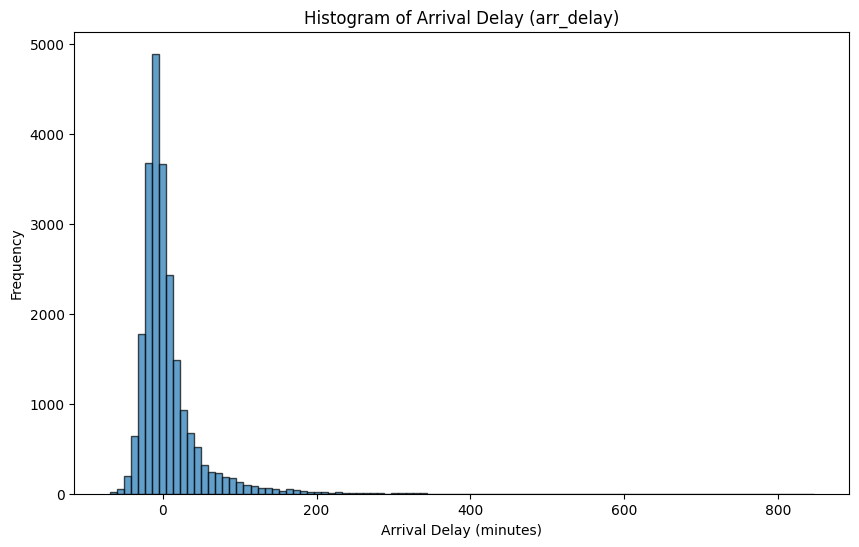

In [191]:
import matplotlib.pyplot as plt

# Convert the 'arr_delay' column to Pandas DataFrame
arr_delay_pd = df.select('arr_delay').toPandas()

# Plot histogram using Matplotlib
plt.figure(figsize=(10,6))
plt.hist(arr_delay_pd['arr_delay'], bins=100, edgecolor='black', alpha=0.7)
plt.title('Histogram of Arrival Delay (arr_delay)')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.show()

## 3.3 Features and Train Test Split

In [194]:
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator


# Select features to use in the model
selected_features = ['dep_delay', 'origin_wind_speed', 'dest_wind_speed', 'distance']

# Handle categorical variables (e.g., carrier, origin, dest)
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) 
            for column in ['carrier']]

# Apply the indexers
for indexer in indexers:
    df = indexer.transform(df)

# Assemble all features into a single vector column
assembler = VectorAssembler(
    inputCols=selected_features + ['carrier_index'],
    outputCol="features"
)

df = assembler.transform(df)

# Scaling Features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(df)
df = scalerModel.transform(df)

# Select the feature vector and the target variable (arr_delay)
df = df.select('features', 'arr_delay')

# Split the data into training and test sets (80% training, 20% testing)
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

## 3.4 Models

### 3.4.1 Linear Regression

In [195]:
from pyspark.ml.regression import LinearRegression

# Create and train the linear regression model
lr = LinearRegression(labelCol="arr_delay", featuresCol="features")
lr_model = lr.fit(train_df)

# Make predictions on the test set
predictions_lr = lr_model.transform(test_df)

24/10/17 11:44:46 WARN Instrumentation: [c6490691] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 11:44:47 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [196]:
print_model_eval_metrics(predictions_lr)

Root Mean Squared Error (RMSE): 16.7417
R²: 0.8245
Adjusted R²: 0.8243


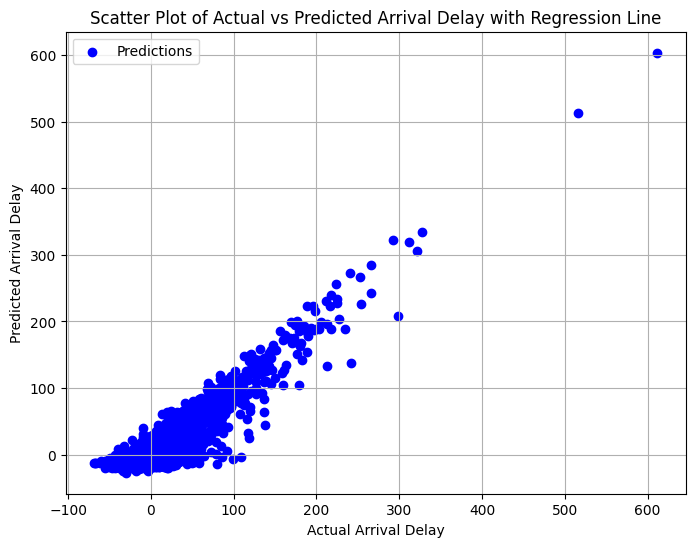

In [197]:
plot_scatter_delay(predictions_lr)

In [198]:
# Print the coefficients
coefficients = lr_model.coefficients

# Feature names (you might want to adjust based on your actual feature columns)
feature_names = ['dep_delay', 'origin_wind_speed', 'dest_wind_speed', 'distance', 'carrier_index']

# Zip the feature names with the corresponding coefficients and print them
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

dep_delay: 1.0150
origin_wind_speed: 0.1578
dest_wind_speed: 0.4738
distance: -0.0027
carrier_index: 0.0004


### 3.4.2 Random Forest Regressor

In [74]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


# Initialize the RandomForestRegressor model
rf = RandomForestRegressor(labelCol="arr_delay", featuresCol="features")

# Create a parameter grid for grid search
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5, 10, 20, 50]) \
    .addGrid(rf.maxDepth, [3, 6]) \
    .build()

# Initialize the evaluator
evaluator = RegressionEvaluator(labelCol="arr_delay", predictionCol="prediction", metricName="rmse")

# Set up 3-fold cross-validation
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # 3-fold cross-validation

# Train the model using cross-validation
cv_model_rf = crossval.fit(train_df)

# Make predictions on the test set
predictions_rf = cv_model_rf.transform(test_df)

In [75]:
print_model_eval_metrics(predictions_rf)

Root Mean Squared Error (RMSE): 22.4114
R²: 0.7201
Adjusted R²: 0.7198


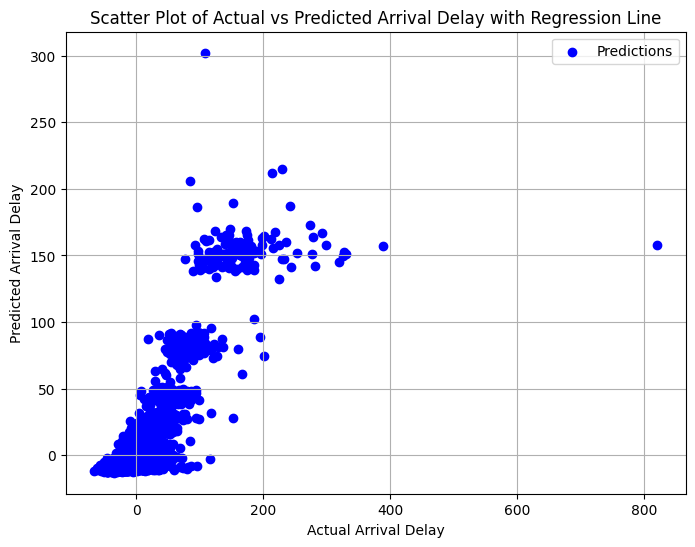

In [76]:
plot_scatter_delay(predictions_rf)

In [77]:
best_model_rf = cv_model_rf.bestModel

print("Random Forest Regressor Best Model Hyperparams:")
print("-"*50)
print(f"numFeatures: {best_model_rf.numFeatures}")
print(f"numTrees: {best_model_rf.getNumTrees}")
print(f"maxDepth: {best_model_rf.getMaxDepth()}")

Random Forest Regressor Best Model Hyperparams:
--------------------------------------------------
numFeatures: 5
numTrees: 50
maxDepth: 6


In [78]:
# Print feature importances
importances = best_model_rf.featureImportances

# Feature names (you should adjust this to match your actual features used in the VectorAssembler)
feature_names = ['dep_delay', 'origin_wind_speed', 'dest_wind_speed', 'air_time', 'distance', 'carrier_index', 'origin_index']

# Zip the feature names with the importances and print them
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")

dep_delay: 0.9208
origin_wind_speed: 0.0191
dest_wind_speed: 0.0163
air_time: 0.0134
distance: 0.0304


### 3.4.3 GBT Regressor

In [79]:
from pyspark.ml.regression import GBTRegressor

# Initialize the GBTRegressor model
gbt = GBTRegressor(labelCol="arr_delay", featuresCol="features")

# Create a parameter grid for grid search
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 50]) \
    .addGrid(gbt.maxDepth, [3, 6]) \
    .build()

# Initialize the evaluator
evaluator = RegressionEvaluator(labelCol="arr_delay", predictionCol="prediction", metricName="rmse")

# Set up 3-fold cross-validation
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # 3-fold cross-validation

# Run cross-validation, and choose the best set of parameters
cv_model_gbt = crossval.fit(train_df)

# Make predictions on the test set
predictions_gbt = cv_model_gbt.transform(test_df)

In [80]:
print_model_eval_metrics(predictions_gbt)

Root Mean Squared Error (RMSE): 21.3940
R²: 0.7450
Adjusted R²: 0.7447


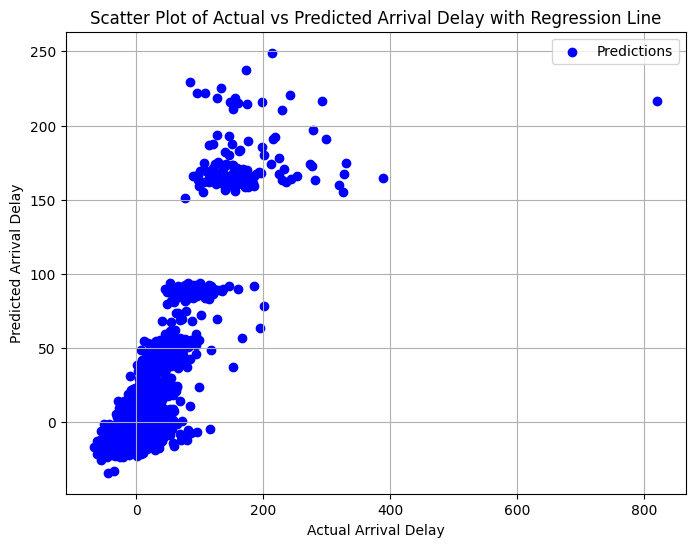

In [81]:
plot_scatter_delay(predictions_gbt)

In [82]:
best_model_gbt = cv_model_gbt.bestModel

print("GBTRegressor Best Model Hyperparams:")
print("-"*40)
print(f"numFeatures: {best_model_gbt.numFeatures}")
print(f"numTrees: {best_model_gbt.getNumTrees}")
print(f"maxDepth: {best_model_gbt.getMaxDepth()}")

GBTRegressor Best Model Hyperparams:
----------------------------------------
numFeatures: 5
numTrees: 50
maxDepth: 3


In [83]:
# Print feature importances
importances = best_model_gbt.featureImportances

# Feature names (you should adjust this to match your actual features used in the VectorAssembler)
feature_names = ['dep_delay', 'origin_wind_speed', 'dest_wind_speed', 'air_time', 'distance', 'carrier_index', 'origin_index']

# Zip the feature names with the importances and print them
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")

dep_delay: 0.8104
origin_wind_speed: 0.0420
dest_wind_speed: 0.0492
air_time: 0.0382
distance: 0.0602


## 3.5 Final Pyspark Model

In [199]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Import the CSV file back into a DataFrame
df = spark.read.csv('df_final.csv', header=True, inferSchema=True)
df = df.select('dep_delay', 'origin_wind_speed', 'dest_wind_speed', 'distance', 'carrier', 'arr_delay')

# Select features to use in the model
num_features = ['dep_delay', 'origin_wind_speed', 'dest_wind_speed', 'distance']

# Handle the categorical variable 'carrier' with StringIndexer
carrier_indexer = StringIndexer(inputCol='carrier', outputCol='carrier_index')

# Assemble all features into a single vector column
assembler = VectorAssembler(
    inputCols=num_features + ['carrier_index'],
    outputCol="features"
)

# Scaling Features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Define the regression model (e.g., Linear Regression)
lr = LinearRegression(featuresCol='scaledFeatures', labelCol='arr_delay')

# Create a pipeline with all stages (StringIndexer, VectorAssembler, StandardScaler, LinearRegression)
pipeline = Pipeline(stages=[carrier_indexer, assembler, scaler, lr])

# Fit the pipeline on the training data
pipeline_model = pipeline.fit(df)

24/10/17 11:46:02 WARN Instrumentation: [ea2abd03] regParam is zero, which might cause numerical instability and overfitting.


### Saving the Final Pyspark Model

In [210]:
# Save the trained Linear Regression model
model_path = "../models/lr_model_pyspark"
pipeline_model.write().overwrite().save(model_path)

## 3.6 Training a Scikit-Learn Model for pickle

In [200]:
df_spark = spark.read.csv('df_final.csv', header=True, inferSchema=True)

In [201]:
import pandas as pd

df = df_spark.toPandas()

In [202]:
df.columns

Index(['id', 'origin', 'origin_airport_name', 'dep_timestamp', 'dep_delay',
       'origin_wind_speed', 'dest', 'dest_airport_name', 'arr_timestamp',
       'arr_delay', 'dest_wind_speed', 'carrier', 'name', 'tailnum', 'flight',
       'air_time', 'distance'],
      dtype='object')

### 3.6.1 Train Test Split

In [203]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

# Assuming df is the DataFrame obtained from the previous step
# Select features and target variable
X = df[['dep_delay', 'origin_wind_speed', 'dest_wind_speed', 'distance', 'carrier']]
y = df['arr_delay']

# Define the columns for scaling and encoding
numeric_features = ['dep_delay', 'origin_wind_speed', 'dest_wind_speed', 'distance']
categorical_features = ['carrier']  # Replace with your actual categorical feature name(s)

# Define the ColumnTransformer to apply different preprocessing to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore',drop='first'), categorical_features)
    ]
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform both training and test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

### 3.6.2 Linear Model

In [204]:
from sklearn.linear_model import LinearRegression

# Create and train the linear regression model
lr = LinearRegression()
lr.fit(X_train_processed, y_train)

LinearRegression()

#### Evaluation

In [205]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Make predictions on the test set
y_pred = lr.predict(X_test_processed)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R²
n = len(y_test)  # Number of observations
p = X_test.shape[1]  # Number of predictors (features)
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print metrics in the desired format
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R²: {r2:.4f}')
print(f'Adjusted R²: {adjusted_r2:.4f}')

Root Mean Squared Error (RMSE): 17.2162
R²: 0.8274
Adjusted R²: 0.8272


### 3.6.3 Linear Model with Regularization and GridSearch

In [206]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Define the model
elastic_net = ElasticNet()

# Define the parameter grid
param_grid = {'alpha':[0.1,1,5,10,50,100],
              'l1_ratio':[.1, .5, .7, .9, .95, .99, 1]}

# verbose number a personal preference
grid_model = GridSearchCV(estimator=elastic_net,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=5)

# Fit the model to the scaled training data
grid_model.fit(X_train_processed, y_train)

# Get the best parameters and score
# best_alpha = grid_model.best_params_['alpha']
# best_l1_ratio = grid_model.best_params_['l1_ratio']
# best_rmse = grid_model.best_score_

print(f'Best alpha (regularization strength): {grid_model.best_params_['alpha']}')
print(f'Best L1 ratio (L1/L2 mix): {grid_model.best_params_['l1_ratio']}')

Best alpha (regularization strength): 0.1
Best L1 ratio (L1/L2 mix): 1


In [207]:
from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np

# Make predictions on the test set using the best estimator from the grid search
y_pred = grid_model.best_estimator_.predict(X_test_processed)

# Calculate metrics
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate Adjusted R²
n = len(y_test)  # Number of observations
p = X_test.shape[1]  # Number of predictors (features)
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print metrics in the desired format
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R²: {r2:.4f}')
print(f'Adjusted R²: {adjusted_r2:.4f}')

Root Mean Squared Error (RMSE): 17.2978
R²: 0.8258
Adjusted R²: 0.8256


### 3.6.4 Final Model

In [208]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
import pickle

X = df[['dep_delay', 'origin_wind_speed', 'dest_wind_speed', 'distance', 'carrier']]
y = df['arr_delay']

# Define the columns for scaling and encoding
numeric_features = ['dep_delay', 'origin_wind_speed', 'dest_wind_speed', 'distance']
categorical_features = ['carrier']  # Replace with your actual categorical feature names

# Define the ColumnTransformer to apply different preprocessing to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Create a pipeline with the preprocessor and the linear regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Fit the pipeline on the training data
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['dep_delay',
                                                   'origin_wind_speed',
                                                   'dest_wind_speed',
                                                   'distance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['carrier'])])),
                ('model', LinearRegression())])

#### Saving the Model

In [211]:
import pickle

with open('../models/lr_model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

# Stop Spark Session

In [182]:
#spark.stop()